In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
##variable declarations
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)


##physical variables
rho = 1
nu = .1
F = 1
dt = .01

#initial conditions
ua = np.zeros((ny, nx))
un = np.zeros((ny, nx))

va = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

pa = np.ones((ny, nx))
pn = np.ones((ny, nx))

b = np.zeros((ny, nx))

Because of the periodic boundary condition, we need to calculate boundaries everywhere

In [3]:
def b_generator(b, rho, dt, u, v, dx, dy):
  first_term = 1/dt * ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx) + (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy))
  second_term = - ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx)) * ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx))
  third_term = -2 * ((v[1:-1,2:] - v[1:-1,0:-2])/(2*dx)) * ((u[2:,1:-1] - u[0:-2,1:-1])/(2*dy))
  fourth_term = - (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy) * (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy)

  b[1:-1, 1:-1] = first_term + second_term + third_term + fourth_term

  #Apply periodic boundary conditions

  end_x_first_term = 1/dt * ((u[1:-1,1] - u[1:-1,-2])/(2*dx) + (v[2:,-1] - v[0:-2,-1])/(2*dy))
  end_x_second_term = - ((u[1:-1,1] - u[1:-1,-2])/(2*dx)) * ((u[1:-1,1] - u[1:-1,-2])/(2*dx))
  end_x_third_term = -2 * ((v[1:-1,1] - v[1:-1,-2])/(2*dx)) * ((u[2:,-1] - u[0:-2,-1])/(2*dy))
  end_x_fourth_term = - (v[2:,-1] - v[0:-2,-1])/(2*dy) * (v[2:,-1] - v[0:-2,-1])/(2*dy)

  b[1:-1, -1] = end_x_first_term + end_x_second_term + end_x_third_term + end_x_fourth_term


  b[1:-1, 0] = b[1:-1, -1]

  return b 

In [4]:
def poisson(p, dx, dy, b, tol=1e-5):
  norm = 1
  while norm > tol:
    p_copy = p.copy()

    p[1:-1,1:-1] = ((dy**2 * (p_copy[1:-1,2:] + p_copy[1:-1,0:-2])) + 
                    (dx**2 * (p_copy[2:,1:-1] + p_copy[0:-2,1:-1]) - 
                     (b[1:-1,1:-1]* dx**2 * dy**2) )) / (2*(dx**2 + dy**2))

    p[1:-1, -1] = ((dy**2 * (p_copy[1:-1,1] + p_copy[1:-1,-2])) + 
                    (dx**2 * (p_copy[2:,-1] + p_copy[0:-2,-1]) - 
                     (b[1:-1,-1]* dx**2 * dy**2) )) / (2*(dx**2 + dy**2))

    p[1:-1, 0] = ((dy**2 * (p_copy[1:-1,1] + p_copy[1:-1,-2])) + 
                    (dx**2 * (p_copy[2:,0] + p_copy[0:-2,0]) - 
                     (b[1:-1,0]* dx**2 * dy**2) )) / (2*(dx**2 + dy**2))
    
    

    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[-1, :] = p[-2,:]     

    norm = (np.sum(np.abs(p[:]) - np.abs(p_copy[:])) /
                np.sum(np.abs(p_copy[:])))   
  return p 

In [5]:
def update_u(u, u_copy, v_copy, p, dt, dx, dy, rho, nu, F):
  first_term = u_copy[1:-1,1:-1]
  second_term = -u_copy[1:-1,1:-1]*(dt/dx)*(u_copy[1:-1,1:-1]-u_copy[1:-1,0:-2])
  third_term = -v_copy[1:-1,1:-1]*(dt/dy)*(u_copy[1:-1,1:-1]-u_copy[0:-2,1:-1])
  fourth_term = -(dt/(2*rho*dx))*(p[1:-1,2:]-p[1:-1,0:-2])
  fifth_term = nu*((dt/dx**2) * (u_copy[1:-1,2:] - 2*u_copy[1:-1,1:-1] + u_copy[1:-1,0:-2]) + 
                   (dt/dy**2) * (u_copy[2:,1:-1] - 2*u_copy[1:-1,1:-1] + u_copy[0:-2,1:-1]) )
  

  u[1:-1,1:-1] = first_term + second_term + third_term + fourth_term + fifth_term + F*dt

  return u

def update_v(v, u_copy, v_copy, p, dt, dx, dy, rho, nu, F):
  first_term = v_copy[1:-1, 1:-1]
  second_term = -u_copy[1:-1, 1:-1] * dt / dx * (v_copy[1:-1, 1:-1] - v_copy[1:-1, 0:-2])
  third_term = -v_copy[1:-1, 1:-1] * dt / dy * (v_copy[1:-1, 1:-1] - v_copy[0:-2, 1:-1])
  fourth_term = -dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1])
  fifth_term = nu * (dt / dx**2 * (v_copy[1:-1, 2:] - 2 * v_copy[1:-1, 1:-1] + v_copy[1:-1, 0:-2]) +
                  dt / dy**2 * (v_copy[2:, 1:-1] - 2 * v_copy[1:-1, 1:-1] + v_copy[0:-2, 1:-1]) )
  
  v[1:-1,1:-1] = first_term + second_term + third_term + fourth_term + fifth_term 

  return v

def channel_flow(epochs, u, v, dt, dx, dy, p, rho, nu, F):
  b = np.zeros((ny,nx))
  u_fun = u.copy()
  v_fun = v.copy()
  for _ in range(epochs):
    un = u.copy()
    vn = v.copy()

    u_base = u.copy()
    v_base = v.copy()

    b = b_generator(b, rho, dt, u, v, dx, dy)
    p = poisson(p, dx, dy, b)
    
    u_fun = update_u(u_base, un, vn, p, dt, dx, dy, rho, nu, F)

    v_fun = update_v(v_base, un, vn, p, dt, dx, dy, rho, nu, F)

    # Periodic BCs
    first_term = un[1:-1,-1]
    second_term = -un[1:-1,-1]*(dt/dx)*(un[1:-1,-1]-un[1:-1,-2])
    third_term = -vn[1:-1,-1]*(dt/dy)*(un[1:-1,-1]-un[0:-2,-1])
    fourth_term = -(dt/(2*rho*dx))*(p[1:-1,1]-p[1:-1,-2])
    fifth_term = nu*((dt/dx**2) * (un[1:-1,1] - 2*un[1:-1,-1] + un[1:-1,-2]) + 
                   (dt/dy**2) * (un[2:,-1] - 2*un[1:-1,-1] + un[0:-2,-1]) )
  

    u_fun[1:-1,-1] = first_term + second_term + third_term + fourth_term + fifth_term + F*dt
    u_fun[1:-1,0] = u_fun[1:-1,-1]

    first_term = vn[1:-1, -1]
    second_term = -un[1:-1, -1] * dt / dx * (vn[1:-1, -1] - vn[1:-1, -2])
    third_term = -vn[1:-1, -1] * dt / dy * (vn[1:-1, -1] - vn[0:-2, -1])
    fourth_term = -dt / (2 * rho * dy) * (p[2:, -1] - p[0:-2, -1])
    fifth_term = nu * (dt / dx**2 * (vn[1:-1, 1] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                  dt / dy**2 * (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1]) )
  
    v_fun[1:-1,-1] = first_term + second_term + third_term + fourth_term + fifth_term 
    
    first_term = vn[1:-1, 0]
    second_term = -un[1:-1, 0] * dt / dx * (vn[1:-1, 0] - vn[1:-1, -2])
    third_term = -vn[1:-1, 0] * dt / dy * (vn[1:-1, 0] - vn[0:-2, 0])
    fourth_term = -dt / (2 * rho * dy) * (p[2:, 0] - p[0:-2, 0])
    fifth_term = nu * (dt / dx**2 * (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -2]) +
                  dt / dy**2 * (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0]) )
    
    v_fun[1:-1,0] = first_term + second_term + third_term + fourth_term + fifth_term 

    u_fun[0, :]  = 0
    u_fun[-1, :] = 0   
    v_fun[0, :]  = 0
    v_fun[-1, :] = 0

    u = u_fun
    v = v_fun

  return u_fun, v_fun, p



In [15]:
u2, v2, p2 = channel_flow(500, ua, va, dt, dx, dy, pa, rho, nu, F)

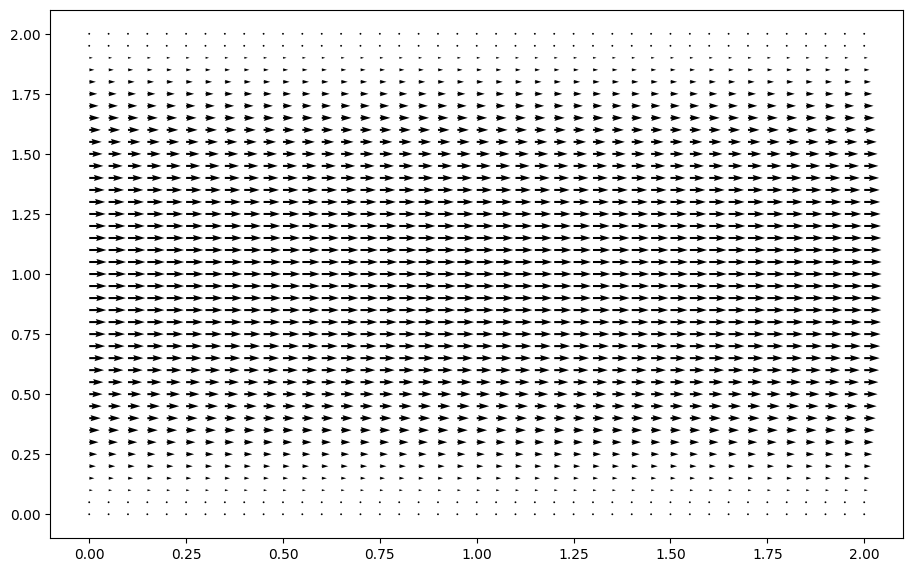

In [16]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.quiver(X, Y, u2, v2);

In [8]:
u2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04548432, 0.04548432, 0.04548432, ..., 0.04548432, 0.04548432,
        0.04548432],
       [0.07267591, 0.07267591, 0.07267591, ..., 0.07267591, 0.07267591,
        0.07267591],
       ...,
       [0.07267591, 0.07267591, 0.07267591, ..., 0.07267591, 0.07267591,
        0.07267591],
       [0.04548432, 0.04548432, 0.04548432, ..., 0.04548432, 0.04548432,
        0.04548432],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
p

NameError: ignored